In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_17990/3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# Load Data

In [2]:
# Import some packages we might need
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import explained_variance_score
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from scipy import stats
import rpy2
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

In [3]:
# Can uncomment to install R packages as needed
#utils = importr('utils')
#utils.install_packages('nflreadr')

In [4]:
# Import R packages
nflreadr = importr('nflreadr')

In [5]:
# Load play-by-play data and convert to pandas df
seasons=[2021,2022,2023]

plays_r = nflreadr.load_pbp(ro.IntVector(seasons))

with (ro.default_converter + pandas2ri.converter).context():
  plays = ro.conversion.get_conversion().rpy2py(plays_r)

Note: nflreadr caches (i.e., stores a saved version) data by default.
If you expect different output try one of the following:
ℹ Restart your R Session or
ℹ Run `nflreadr::.clear_cache()`.
To disable this warning, run `options(nflreadr.verbose = FALSE)` or add it to your .Rprofile
This message is displayed once every 8 hours.


In [6]:
# Encode roof labels into categorical variables
plays['roof_cat'] = LabelEncoder().fit(plays['roof']).transform(plays['roof'])

# Calculate if possession team is home team
plays['posteam_ishome'] = (plays['posteam'] == plays['home_team']).values.astype(int)

# Assign down labels to kickoffs (0th down) and extra points or 2pts (5th down)
plays.loc[ plays['down'].isna() & (plays['play_type'].isin(['kickoff'])), 'down' ] = 0.  # kickoffs are labeled as 0th down
plays.loc[ plays['down'].isna() & (plays['play_type'].isin(['extra_point','run','pass'])), 'down' ] = 5.  # extra points and 2pt attempts are labeled as 5th down

# Drop any unlabeled downs
plays = plays.loc[ ~plays['down'].isna() ] # TODO: this drops a few plays, mostly penalties on extra points, not worth the hassle for now

# Index by gameid and playid
plays = plays.set_index(['game_id','play_id']).sort_index(level=[0,1],ascending=[True,True])

# Drop any unused columns
plays = plays[['home_team','away_team','qtr','half_seconds_remaining','down','ydstogo','play_type','posteam','posteam_ishome','yardline_100','sp','posteam_score','posteam_score_post','defteam_score','defteam_score_post','score_differential','score_differential_post','roof','roof_cat','posteam_timeouts_remaining','defteam_timeouts_remaining','ep','epa']]

In [7]:
# Can uncomment to print all available columns
#for c in plays.columns:
#    print(c)

In [8]:
# Display head of df
plays.head(60)

home_team away_team  qtr  half_seconds_remaining  \
game_id         play_id                                                    
2021_01_ARI_TEN 40.0          TEN       ARI  1.0                  1800.0   
                55.0          TEN       ARI  1.0                  1800.0   
                76.0          TEN       ARI  1.0                  1763.0   
                100.0         TEN       ARI  1.0                  1722.0   
                122.0         TEN       ARI  1.0                  1719.0   
                152.0         TEN       ARI  1.0                  1707.0   
                181.0         TEN       ARI  1.0                  1675.0   
                218.0         TEN       ARI  1.0                  1646.0   
                253.0         TEN       ARI  1.0                  1614.0   
                282.0         TEN       ARI  1.0                  1600.0   
                303.0         TEN       ARI  1.0                  1562.0   
                343.0         TEN       ARI  1.0                  1534.0   
                386.0         TEN       ARI  1.0                  1508.0   
                410.0         TEN       ARI  1.0                  1469.0   
                432.0         TEN       ARI  1.0                  1466.0   
                451.0         TEN       ARI  1.0                  1462.0   
                473.0         TEN       ARI  1.0                  1457.0   
                494.0         TEN       ARI  1.0                  1416.0   
                559.0         TEN       ARI  1.0                  1410.0   
                599.0         TEN       ARI  1.0                  1410.0   
                621.0         TEN       ARI  1.0                  1406.0   
                660.0         TEN       ARI  1.0                  1398.0   
                685.0         TEN       ARI  1.0                  1391.0   
                701.0         TEN       ARI  1.0                  1391.0   
                716.0         TEN       ARI  1.0                  1391.0   
                737.0         TEN       ARI  1.0                  1344.0   
                769.0         TEN       ARI  1.0                  1319.0   
                791.0         TEN       ARI  1.0                  1314.0   
                816.0         TEN       ARI  1.0                  1304.0   
                839.0         TEN       ARI  1.0                  1264.0   
                863.0         TEN       ARI  1.0                  1229.0   
                885.0         TEN       ARI  1.0                  1226.0   
                911.0         TEN       ARI  1.0                  1219.0   
                930.0         TEN       ARI  1.0                  1174.0   
                954.0         TEN       ARI  1.0                  1129.0   
                983.0         TEN       ARI  1.0                  1090.0   
                1011.0        TEN       ARI  1.0                  1044.0   
                1032.0        TEN       ARI  1.0                  1009.0   
                1053.0        TEN       ARI  1.0                   966.0   
                1072.0        TEN       ARI  1.0                   940.0   
                1090.0        TEN       ARI  1.0                   931.0   
                1128.0        TEN       ARI  2.0                   900.0   
                1152.0        TEN       ARI  2.0                   860.0   
                1185.0        TEN       ARI  2.0                   856.0   
                1206.0        TEN       ARI  2.0                   838.0   
                1230.0        TEN       ARI  2.0                   798.0   
                1254.0        TEN       ARI  2.0                   759.0   
                1286.0        TEN       ARI  2.0                   740.0   
                1323.0        TEN       ARI  2.0                   710.0   
                1344.0        TEN       ARI  2.0                   663.0   
                1369.0        TEN       ARI  2.0                   659.0

# Calculate Expected Points

In [9]:
###
def NextPointsScored(df):
    """
    """
    # Initialize data
    num_plays = len(df)
    
    time_remaining = df['half_seconds_remaining'].values
    posteam = df['posteam'].values
    delta = df['score_differential_post'].values - df['score_differential'].values
    scoring_play = df['sp'].values.astype('bool')
    fifth_down = df['down'].values > 4.5 
    
    zeros = 0.*df['down']
    result = np.zeros(num_plays)
    
    # Loop over current plays
    i = 0
    while i < num_plays:
        t_now = time_remaining[i]
        # Loop over future plays
        for j in range(i,num_plays):
            # Check if time has run out
            if time_remaining[j] > t_now:
                # No score before time expires
                break
                
            # Check if it's a scoring play or 5th down play (extra point or 2pt)
            elif scoring_play[j] or fifth_down[j]:
                # Record any necessary score
                result[i:j+1][posteam[i:j+1] == posteam[j]] = delta[j]
                result[i:j+1][posteam[i:j+1] != posteam[j]] = -delta[j]  # TODO: deal with NANs for teams
                break
        
        # Advance current play forward
        i = j + 1
                
    # Return result
    return zeros + result

In [10]:
# Calculate next points scored
plays['next_points'] = plays.groupby('game_id').apply(NextPointsScored).values

In [11]:
# Display some features we will use in our fitting
plays[['half_seconds_remaining','qtr','down','ydstogo','yardline_100','posteam','next_points','score_differential','score_differential_post']].head(60)

half_seconds_remaining  qtr  down  ydstogo  \
game_id         play_id                                               
2021_01_ARI_TEN 40.0                     1800.0  1.0   0.0      0.0   
                55.0                     1800.0  1.0   1.0     10.0   
                76.0                     1763.0  1.0   2.0     13.0   
                100.0                    1722.0  1.0   3.0     10.0   
                122.0                    1719.0  1.0   4.0     10.0   
                152.0                    1707.0  1.0   1.0     10.0   
                181.0                    1675.0  1.0   1.0     10.0   
                218.0                    1646.0  1.0   1.0     18.0   
                253.0                    1614.0  1.0   2.0     17.0   
                282.0                    1600.0  1.0   1.0      9.0   
                303.0                    1562.0  1.0   2.0      9.0   
                343.0                    1534.0  1.0   2.0     14.0   
                386.0                    1508.0  1.0   2.0     24.0   
                410.0                    1469.0  1.0   3.0     16.0   
                432.0                    1466.0  1.0   4.0     16.0   
                451.0                    1462.0  1.0   0.0      0.0   
                473.0                    1457.0  1.0   1.0     10.0   
                494.0                    1416.0  1.0   2.0     11.0   
                559.0                    1410.0  1.0   1.0      1.0   
                599.0                    1410.0  1.0   1.0      5.0   
                621.0                    1406.0  1.0   2.0      5.0   
                660.0                    1398.0  1.0   3.0      5.0   
                685.0                    1391.0  1.0   5.0      0.0   
                701.0                    1391.0  1.0   0.0      0.0   
                716.0                    1391.0  1.0   1.0     10.0   
                737.0                    1344.0  1.0   2.0      8.0   
                769.0                    1319.0  1.0   3.0     16.0   
                791.0                    1314.0  1.0   4.0     16.0   
                816.0                    1304.0  1.0   1.0     10.0   
                839.0                    1264.0  1.0   2.0      6.0   
                863.0                    1229.0  1.0   3.0      3.0   
                885.0                    1226.0  1.0   4.0      3.0   
                911.0                    1219.0  1.0   1.0     10.0   
                930.0                    1174.0  1.0   2.0     16.0   
                954.0                    1129.0  1.0   3.0     12.0   
                983.0                    1090.0  1.0   4.0      4.0   
                1011.0                   1044.0  1.0   1.0     10.0   
                1032.0                   1009.0  1.0   2.0     11.0   
                1053.0                    966.0  1.0   3.0      9.0   
                1072.0                    940.0  1.0   4.0     17.0   
                1090.0                    931.0  1.0   1.0     10.0   
                1128.0                    900.0  2.0   2.0     12.0   
                1152.0                    860.0  2.0   3.0      2.0   
                1185.0                    856.0  2.0   1.0     10.0   
                1206.0                    838.0  2.0   2.0      7.0   
                1230.0                    798.0  2.0   1.0     10.0   
                1254.0                    759.0  2.0   2.0      7.0   
                1286.0                    740.0  2.0   1.0     10.0   
                1323.0                    710.0  2.0   1.0     13.0   
                1344.0                    663.0  2.0   2.0      5.0   
                1369.0                    659.0  2.0   5.0      0.0   
                1385.0                    659.0  2.0   0.0      0.0   
                1409.0                    659.0  2.0   1.0     10.0   
                1431.0                    656.0  2.0   2.0     10.0   
                1455.0                    628.0  

In [12]:
# Select the features we will use in our expected points model, make sure they don't have any lookahead!

# Simple model, reproduces bulk of the effect
#fit_cols = ['down','ydstogo','yardline_100']

# More involved model, tries to reproduce the feature set found at https://www.nflfastr.com/reference/calculate_expected_points.html
fit_cols = ['down','ydstogo','yardline_100','half_seconds_remaining','posteam_timeouts_remaining','defteam_timeouts_remaining','roof_cat','posteam_ishome']

# Most involved model, gives best predictive performance...but is there a limit to how much context we want to provide? 
#fit_cols = ['down','ydstogo','yardline_100','half_seconds_remaining','posteam_timeouts_remaining','defteam_timeouts_remaining','roof_cat','posteam_ishome','qtr','score_differential']

#Create dictionary to store best model
model_dic = {}
model_dic['oos_rho'] = -np.inf
model_dic['oos_predictions'] = None
model_dic['final_model'] = None
model_dic['final_hyperparams'] = [None,None]

# Loop over random forest hyperparameters
n_splits = 10
n_estimators = 300
for max_depth in range(7,13):
    for min_samples_leaf in [1]:

        # Get feature and target variables
        X = plays[fit_cols].values
        Y = plays['next_points'].values

        # Set up a k-folds cross-validation
        kf = KFold(n_splits=n_splits)
        kf.get_n_splits(X)

        cum_Y_test = np.ones_like(Y) * np.nan
        cum_Y_pred = np.ones_like(Y) * np.nan

        for train_index_raw,test_index in kf.split(X):

            # Add a buffer around training data to prevent any accidental lookahead/leakage
            buffer_low = np.arange(test_index[0] - 100, test_index[0])
            buffer_high = np.arange(test_index[-1]+1, test_index[-1] + 101)
            train_index = np.array([ x for x in train_index_raw if ( (x not in buffer_low) & (x not in buffer_high) ) ])
            
            X_train, X_test = X[train_index], X[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]

            # Train random forest model with current hyperparameters
            rf_exp = ExtraTreesRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_samples_leaf)
            rf_exp.fit(X_train, Y_train)

            cum_Y_test[test_index] = Y_test
            cum_Y_pred[test_index] = rf_exp.predict(X_test)
        
        # Train random forest model on all data
        rf_exp = ExtraTreesRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_samples_leaf)
        rf_exp.fit(X, Y)

        print()
        print('#####')
        print()
        print(max_depth, min_samples_leaf)
        print()
        print('feature importances:')
        print()
        for a,b in zip(fit_cols,rf_exp.feature_importances_):
            print(a,b)
        print()
        print('Performance metrics:')
        print()
        print('var, IS:', explained_variance_score(Y,rf_exp.predict(X)))
        print('var, OOS:', explained_variance_score(cum_Y_test,cum_Y_pred))
        print()
        print('rho, IS:', stats.pearsonr(Y,rf_exp.predict(X))[0])
        print('rho, OOS:', stats.pearsonr(cum_Y_test,cum_Y_pred)[0])
        print()
        print('mde, IS:', median_absolute_error(Y,rf_exp.predict(X)))
        print('mde, OOS:', median_absolute_error(cum_Y_test,cum_Y_pred))
        print()
        print('mae, IS:', mean_absolute_error(Y,rf_exp.predict(X)))
        print('mae, OOS:', mean_absolute_error(cum_Y_test,cum_Y_pred))
        print()
        print('mse, IS:', mean_squared_error(Y,rf_exp.predict(X)))
        print('mse, OOS:', mean_squared_error(cum_Y_test,cum_Y_pred))

        # Store the model that performed best out-of-sample (OOS)
        this_rho = stats.pearsonr(cum_Y_test,cum_Y_pred)[0]
        if this_rho > model_dic['oos_rho']:
            model_dic['oos_rho'] = this_rho
            model_dic['oos_predictions'] = cum_Y_pred
            model_dic['final_model'] = rf_exp
            model_dic['final_hyperparams'] = [max_depth, min_samples_leaf]


#####

7 1

feature importances:

down 0.2606052537441496
ydstogo 0.03152274997882826
yardline_100 0.6831399538646953
half_seconds_remaining 0.004743031475433986
posteam_timeouts_remaining 0.0021214868517285893
defteam_timeouts_remaining 0.009445836781729042
roof_cat 0.0019061412451801592
posteam_ishome 0.00651554605825521

Performance metrics:

var, IS: 0.1313835780860354
var, OOS: 0.12776888971138944

rho, IS: 0.3631838038323617
rho, OOS: 0.3578928780026224

mde, IS: 2.72299445608441
mde, OOS: 2.743053363576306

mae, IS: 3.164680936895388
mae, OOS: 3.171038300331339

mse, IS: 15.224422732383651
mse, OOS: 15.287778713886569

#####

8 1

feature importances:

down 0.25423340246612797
ydstogo 0.03577592539426092
yardline_100 0.6719888231930062
half_seconds_remaining 0.00884706582281211
posteam_timeouts_remaining 0.0038177075335779206
defteam_timeouts_remaining 0.012252090221375864
roof_cat 0.004219868482565649
posteam_ishome 0.0088651168862733

Performance metrics:

var, IS: 0.13572773

old model, rho:  0.36510377726849164
new model, rho:  0.36025595102831254

Correlation between new and old model:  0.978144738048548



/tmp/ipykernel_17990/3752907674.py:18: RuntimeWarning: invalid value encountered in scalar divide
  avg_new += [ ( (plays['ep_new'] >= bins[i]) * (plays['ep_new'] <= bins[i+1]) * plays['next_points'] ).sum() / ( (plays['ep_new'] >= bins[i]) & (plays['ep_new'] <= bins[i+1]) ).sum() ]
/tmp/ipykernel_17990/3752907674.py:19: RuntimeWarning: invalid value encountered in scalar divide
  avg_old += [ ( (plays['ep'] >= bins[i]) * (plays['ep'] <= bins[i+1]) * plays['next_points'] ).sum() / ( (plays['ep'] >= bins[i]) & (plays['ep'] <= bins[i+1]) ).sum() ]


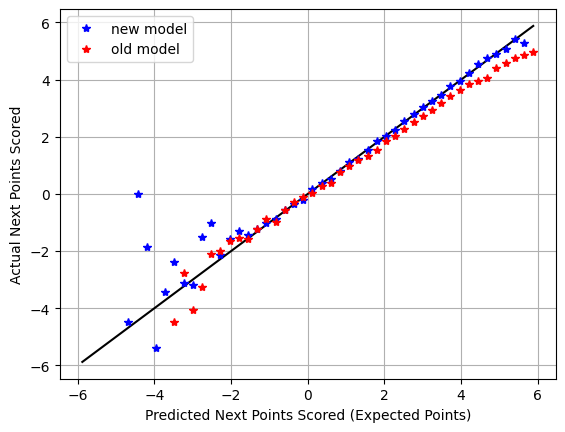

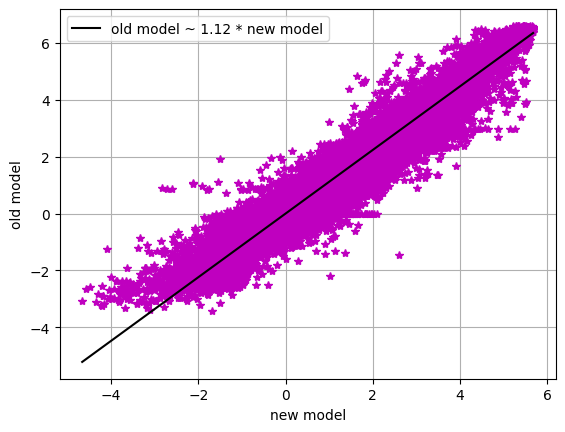

In [19]:
# Calculate some metrics for the old and new models

plays['ep_new'] = model_dic['oos_predictions']
print('old model, rho: ', stats.pearsonr(plays['ep'], plays['next_points'])[0])
print('new model, rho: ', stats.pearsonr(plays['ep_new'], plays['next_points'])[0])
print()

print('Correlation between new and old model: ', stats.pearsonr(plays['ep_new'],plays['ep'])[0])
print()

# Evaluate the calibration of the EP models
bins = np.linspace(-6, 6, 51)
bin_centers = 0.5*(bins[:-1] + bins[1:])

avg_new = []
avg_old = []
for i,bin_center in enumerate(bin_centers):
    avg_new += [ ( (plays['ep_new'] >= bins[i]) * (plays['ep_new'] <= bins[i+1]) * plays['next_points'] ).sum() / ( (plays['ep_new'] >= bins[i]) & (plays['ep_new'] <= bins[i+1]) ).sum() ]
    avg_old += [ ( (plays['ep'] >= bins[i]) * (plays['ep'] <= bins[i+1]) * plays['next_points'] ).sum() / ( (plays['ep'] >= bins[i]) & (plays['ep'] <= bins[i+1]) ).sum() ]

plt.plot(bin_centers, bin_centers, 'k-')
plt.plot(bin_centers, avg_new, 'b*', label='new model')
plt.plot(bin_centers, avg_old, 'r*', label='old model')
plt.xlabel('Predicted Next Points Scored (Expected Points)')
plt.ylabel('Actual Next Points Scored')
plt.grid()
plt.legend()

plt.show()

# Plot the old and new EP models predictions against each other
beta = np.nansum(plays['ep'] * plays['ep_new']) / np.nansum(plays['ep_new'] * plays['ep_new'])

plt.plot(plays['ep_new'], plays['ep'], 'm*',)
plt.plot(np.linspace(plays['ep_new'].min(),plays['ep_new'].max(),10), beta * np.linspace(plays['ep_new'].min(),plays['ep_new'].max(),10), 'k-', label=f"old model ~ {beta:.2f} * new model")
plt.xlabel('new model')
plt.ylabel('old model')
plt.legend()
plt.grid()

plt.show()

In [20]:
# Predictive performance by down
for x in range(0,6):
    print(f'old model, rho, {x}: ', stats.pearsonr(plays[ plays['down'] == x ]['ep'], plays[ plays['down'] == x ]['next_points'])[0])
    print(f'new model, rho, {x}: ', stats.pearsonr(plays[ plays['down'] == x ]['ep_new'], plays[ plays['down'] == x ]['next_points'])[0])
    print()

old model, rho, 0:  0.06182621252428399
new model, rho, 0:  0.046669602603049934

old model, rho, 1:  0.3423763367736744
new model, rho, 1:  0.3380177046608758

old model, rho, 2:  0.35013883721108235
new model, rho, 2:  0.3442444867220184

old model, rho, 3:  0.3578017748956618
new model, rho, 3:  0.3528487951549319

old model, rho, 4:  0.3836319378638223
new model, rho, 4:  0.37439076582638703

old model, rho, 5:  0.06518075110353193
new model, rho, 5:  0.08631204994735014



In [21]:
model_dic

{'oos_rho': 0.36025595102831254,
 'oos_predictions': array([1.07290318, 1.22929653, 0.71752711, ..., 3.72008407, 3.92601132,
        5.15642735]),
 'final_model': ExtraTreesRegressor(max_depth=10, n_estimators=300),
 'final_hyperparams': [10, 1]}